Epoch 1/100
94/94 [==============================] - 4s 38ms/step - loss: 0.0211
Epoch 2/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 8/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 9/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 10/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 11/100
94/94 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 12/100
94/94 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 13/100
94/94 [==============

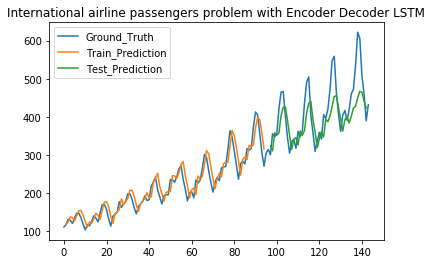

In [19]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(RepeatVector(3))
model.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.title("International airline passengers problem with Encoder Decoder LSTM")
plt.plot(scaler.inverse_transform(dataset), label="Ground_Truth")
plt.plot(trainPredictPlot, label="Train_Prediction")
plt.plot(testPredictPlot, label="Test_Prediction")
plt.legend()
plt.savefig("Encoder_Decoder", dpi=1000)
plt.show()

In [ ]:
print model.summary()